# Imports

In [25]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
import json

import torch
import torch.nn as nn
import torch.optim as optim

from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV

from sklearn.model_selection import StratifiedKFold
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import DataLoader, TensorDataset

from sklearn.utils.class_weight import compute_class_weight

from pypfopt import HRPOpt
import matplotlib.pyplot as plt
from skorch import NeuralNetClassifier
from scipy.stats import ttest_rel
import matplotlib.dates as mdates
from sklearn.metrics import f1_score

# Loading Data and Seperating Feature/Target 

In [10]:

# Load the data
file_name = "top_100_sp500_stock_data.csv"
#file_name = "top_7_sp500_stock_data.csv" # Used for testing models first
all_stocks_data = pd.read_csv(file_name)

# Create the target variable
all_stocks_data['Return_90d'] = (
    all_stocks_data.groupby('Ticker')['Close'].shift(-90) / all_stocks_data['Close'] - 1
)

# Modify the target variable to have labels 0 and 1
all_stocks_data['Target'] = (all_stocks_data['Return_90d'] > 0).astype(int)

In [11]:
# Drop rows with NaN values
all_stocks_data.dropna(inplace=True)

# Select features
feature_columns = [
    col for col in all_stocks_data.columns if col not in ['Ticker', 'Return_90d', 'Target', 'Date']
]
X = all_stocks_data[feature_columns]
y = all_stocks_data['Target']

# Handle infinity values
X = X.replace([np.inf, -np.inf], np.nan)

# Remove rows with NaN values
X = X.dropna()
y = y.loc[X.index]  


# Set up Random Search Parameters

In [12]:
# Define the parameter grid
param_dist = {
    'n_estimators': [10, 50, 100],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3],
    'min_child_weight': [1, 3, 5]
}

# Initialize variables
start_year = 2014
end_year = 2022
yearly_results = []
trained_models = []

# Define feature columns
feature_columns = [
    col for col in all_stocks_data.columns if col not in ['Ticker', 'Return_90d', 'Target', 'Date']
]

# Initialize MinMaxScaler
scaler = MinMaxScaler()


In [13]:
import json

try:
    xgb_best_models = json.load(open("xgb_hyper_params.json"))
except FileNotFoundError:
    open("xgb_hyper_params.json", "x").write("{}")
    xgb_best_models = {}

# Adjust yearly data processing to include the first 30 and last 90 days
for year in range(start_year, end_year + 1):
    with open("xgb_hyper_params.json", "w") as f:
        f.write(json.dumps(xgb_best_models))
    
    print(f"\nProcessing year {year}...")

    # Filter data for the current year
    current_year_data = all_stocks_data[
        (all_stocks_data['Date'] >= f"{year}-01-01") & 
        (all_stocks_data['Date'] <= f"{year}-12-31")
    ]

    # Get data for the previous year to handle the first 30 days
    previous_year_data = all_stocks_data[
        (all_stocks_data['Date'] >= f"{year - 1}-12-01") & 
        (all_stocks_data['Date'] <= f"{year - 1}-12-31")
    ]

    # Get data for the next year to handle the last 90 days
    next_year_data = all_stocks_data[
        (all_stocks_data['Date'] >= f"{year + 1}-01-01") & 
        (all_stocks_data['Date'] <= f"{year + 1}-03-31")
    ]

    # Concatenate previous, current, and next year's data where applicable
    yearly_data = pd.concat([previous_year_data, current_year_data, next_year_data])

    # Skip the year if no data is available
    if yearly_data.empty:
        print(f"No data available for year {year}. Skipping...")
        continue

    # Select features and target for the year
    X_year = yearly_data[feature_columns]
    y_year = yearly_data['Target']

    # Handle missing or infinity values
    X_year = X_year.replace([np.inf, -np.inf], np.nan).dropna()
    y_year = y_year.loc[X_year.index]

    # Skip if the filtered X_year is empty
    if X_year.empty:
        print(f"No valid data for year {year} after filtering. Skipping...")
        continue

    # Reset indices of both X_year and y_year for alignment
    X_year = X_year.reset_index(drop=True)
    y_year = y_year.reset_index(drop=True)

    # Normalize the features using the scaler
    X_year_scaled = scaler.fit_transform(X_year)

    # Split the data into Training (60%) and Temp (40%) sets
    X_train, X_temp, y_train, y_temp = train_test_split(
        X_year_scaled, y_year, test_size=0.4, random_state=42, stratify=y_year
    )

    # Split Temp set into Validation (20%) and Test (20%) sets
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
    )

    # Debugging: Check data splits
    print(f"Training Set Size: {X_train.shape[0]} samples")
    print(f"Validation Set Size: {X_val.shape[0]} samples")
    print(f"Testing Set Size: {X_test.shape[0]} samples")
    if year not in xgb_best_models:
        # Instantiate the XGBClassifier with GPU support
        xgb_model = XGBClassifier(
            random_state=42, 
            eval_metric='logloss', 
            tree_method='gpu_hist',  # Use GPU for histogram building
            predictor='gpu_predictor'  # Use GPU for prediction
        )

        # Set up Stratified K-Fold Cross-Validation
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

        # RandomizedSearchCV with `cv=skf`
        random_search = RandomizedSearchCV(
            estimator=xgb_model,
            param_distributions=param_dist,
            n_iter=50,
            scoring='accuracy',
            cv=skf,
            verbose=2,
            random_state=42,
            n_jobs=6
        )

        # Perform the random search (This is done on training data)
        random_search.fit(X_train, y_train)
        
        best_xgb_model = random_search.best_estimator_    
    else:
        best_xgb_model = XGBClassifier(
            random_state=42, 
            eval_metric='logloss', 
            tree_method='gpu_hist',  # Use GPU for histogram building
            predictor='gpu_predictor'  # Use GPU for prediction
            **xgb_best_models[str(year)]
        )
        
    # Get the best model from the random search

    # Print the best hyperparameters
    print(f"Best Hyperparameters for {year}:", random_search.best_params_)
    xgb_best_models[str(year)] = random_search.best_params_
    # Store the trained model and yearly data for evaluation
    trained_models.append((best_xgb_model, random_search.best_params_))
    yearly_results.append((X_year_scaled, y_year, yearly_data.reset_index(drop=True)))

    print(f"Year {year} processing completed.")


Processing year 2014...
Training Set Size: 15493 samples
Validation Set Size: 5164 samples
Testing Set Size: 5165 samples
Fitting 5 folds for each of 50 candidates, totalling 250 fits


c:\Users\Alec\Projects\MyEnv\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:11:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\Alec\Projects\MyEnv\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:11:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)


Best Hyperparameters for 2014: {'subsample': 1.0, 'n_estimators': 100, 'min_child_weight': 1, 'max_depth': 10, 'learning_rate': 0.2, 'gamma': 0.2, 'colsample_bytree': 0.8}
Year 2014 processing completed.

Processing year 2015...
Training Set Size: 19303 samples
Validation Set Size: 6435 samples
Testing Set Size: 6435 samples
Fitting 5 folds for each of 50 candidates, totalling 250 fits


c:\Users\Alec\Projects\MyEnv\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:30:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\Alec\Projects\MyEnv\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:30:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)


Best Hyperparameters for 2015: {'subsample': 1.0, 'n_estimators': 100, 'min_child_weight': 1, 'max_depth': 10, 'learning_rate': 0.2, 'gamma': 0.2, 'colsample_bytree': 0.8}
Year 2015 processing completed.

Processing year 2016...
Training Set Size: 19438 samples
Validation Set Size: 6480 samples
Testing Set Size: 6480 samples
Fitting 5 folds for each of 50 candidates, totalling 250 fits


c:\Users\Alec\Projects\MyEnv\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:45:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\Alec\Projects\MyEnv\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:45:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)


Best Hyperparameters for 2016: {'subsample': 1.0, 'n_estimators': 100, 'min_child_weight': 1, 'max_depth': 10, 'learning_rate': 0.2, 'gamma': 0.2, 'colsample_bytree': 0.8}
Year 2016 processing completed.

Processing year 2017...
Training Set Size: 19380 samples
Validation Set Size: 6460 samples
Testing Set Size: 6461 samples
Fitting 5 folds for each of 50 candidates, totalling 250 fits


c:\Users\Alec\Projects\MyEnv\Lib\site-packages\xgboost\core.py:158: UserWarning: [02:04:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\Alec\Projects\MyEnv\Lib\site-packages\xgboost\core.py:158: UserWarning: [02:04:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)


Best Hyperparameters for 2017: {'subsample': 1.0, 'n_estimators': 100, 'min_child_weight': 1, 'max_depth': 10, 'learning_rate': 0.2, 'gamma': 0.2, 'colsample_bytree': 0.8}
Year 2017 processing completed.

Processing year 2018...
Training Set Size: 19264 samples
Validation Set Size: 6421 samples
Testing Set Size: 6422 samples
Fitting 5 folds for each of 50 candidates, totalling 250 fits


c:\Users\Alec\Projects\MyEnv\Lib\site-packages\xgboost\core.py:158: UserWarning: [02:24:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\Alec\Projects\MyEnv\Lib\site-packages\xgboost\core.py:158: UserWarning: [02:24:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)


Best Hyperparameters for 2018: {'subsample': 1.0, 'n_estimators': 100, 'min_child_weight': 1, 'max_depth': 10, 'learning_rate': 0.2, 'gamma': 0.2, 'colsample_bytree': 0.8}
Year 2018 processing completed.

Processing year 2019...
Training Set Size: 19292 samples
Validation Set Size: 6431 samples
Testing Set Size: 6431 samples
Fitting 5 folds for each of 50 candidates, totalling 250 fits


c:\Users\Alec\Projects\MyEnv\Lib\site-packages\xgboost\core.py:158: UserWarning: [02:40:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\Alec\Projects\MyEnv\Lib\site-packages\xgboost\core.py:158: UserWarning: [02:40:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)


Best Hyperparameters for 2019: {'subsample': 1.0, 'n_estimators': 100, 'min_child_weight': 1, 'max_depth': 10, 'learning_rate': 0.2, 'gamma': 0.2, 'colsample_bytree': 0.8}
Year 2019 processing completed.

Processing year 2020...
Training Set Size: 19549 samples
Validation Set Size: 6516 samples
Testing Set Size: 6517 samples
Fitting 5 folds for each of 50 candidates, totalling 250 fits


c:\Users\Alec\Projects\MyEnv\Lib\site-packages\xgboost\core.py:158: UserWarning: [02:59:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\Alec\Projects\MyEnv\Lib\site-packages\xgboost\core.py:158: UserWarning: [02:59:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)


Best Hyperparameters for 2020: {'subsample': 1.0, 'n_estimators': 100, 'min_child_weight': 1, 'max_depth': 10, 'learning_rate': 0.2, 'gamma': 0.2, 'colsample_bytree': 0.8}
Year 2020 processing completed.

Processing year 2021...
Training Set Size: 19759 samples
Validation Set Size: 6586 samples
Testing Set Size: 6587 samples
Fitting 5 folds for each of 50 candidates, totalling 250 fits


c:\Users\Alec\Projects\MyEnv\Lib\site-packages\xgboost\core.py:158: UserWarning: [03:19:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\Alec\Projects\MyEnv\Lib\site-packages\xgboost\core.py:158: UserWarning: [03:19:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)


Best Hyperparameters for 2021: {'subsample': 1.0, 'n_estimators': 100, 'min_child_weight': 1, 'max_depth': 10, 'learning_rate': 0.2, 'gamma': 0.2, 'colsample_bytree': 0.8}
Year 2021 processing completed.

Processing year 2022...
Training Set Size: 19780 samples
Validation Set Size: 6593 samples
Testing Set Size: 6594 samples
Fitting 5 folds for each of 50 candidates, totalling 250 fits


c:\Users\Alec\Projects\MyEnv\Lib\site-packages\xgboost\core.py:158: UserWarning: [03:41:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\Alec\Projects\MyEnv\Lib\site-packages\xgboost\core.py:158: UserWarning: [03:41:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)


Best Hyperparameters for 2022: {'subsample': 1.0, 'n_estimators': 100, 'min_child_weight': 1, 'max_depth': 10, 'learning_rate': 0.2, 'gamma': 0.2, 'colsample_bytree': 0.8}
Year 2022 processing completed.


# Make an XGBoost Classifier with the best parameters

In [26]:
# Initialize a dictionary to store models and F1-scores for each year
yearly_models = {}
f1_scores_per_year = {}  # Ensure this name doesn't conflict with sklearn functions

# Function to evaluate and print metrics while saving F1-scores
def evaluate_model(model, X, y, dataset_name, year):
    # Debugging: Check if f1_score is callable
    print(f"Type of f1_score before calling: {type(f1_score)}")  # Debugging line

    # Ensure that no shadowing occurs for f1_score
    y_pred = model.predict(X)
    accuracy = accuracy_score(y, y_pred)
    f1_result = f1_score(y, y_pred, average='weighted')  # Explicitly call f1_score from sklearn
    print(f"\n{dataset_name} Accuracy: {accuracy:.2f}")
    print(f"{dataset_name} F1-Score: {f1_result:.4f}")
    print(f"{dataset_name} Classification Report:")
    print(classification_report(y, y_pred))
    print(f"{dataset_name} Confusion Matrix:")
    print(confusion_matrix(y, y_pred))

    # Save F1-scores for the test set only
    if "Test Set" in dataset_name:
        f1_scores_per_year[year] = f1_result  # Save the result in the dictionary

# Loop through each year and train/evaluate the model
for year, (X_year_scaled, y_year, yearly_data) in zip(range(start_year, end_year + 1), yearly_results):
    print(f"\nTraining and evaluating XGBoost model for year {year}...")

    # Retrieve best hyperparameters for the year
    best_params = trained_models[year - start_year][1]

    # Create a new XGBoost classifier with the best parameters
    xgb_model = XGBClassifier(
        **best_params,
        random_state=42,
        eval_metric='logloss',
        tree_method='gpu_hist',  # Ensure GPU usage
        predictor='gpu_predictor'
    )

    # Split the yearly data into training, validation, and test sets
    X_train, X_temp, y_train, y_temp = train_test_split(
        X_year_scaled, y_year, test_size=0.4, random_state=42, stratify=y_year
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
    )

    # Train the XGBoost classifier
    xgb_model.fit(X_train, y_train)

    # Evaluate the model on training, validation, and test sets
    evaluate_model(xgb_model, X_train, y_train, f"Year {year} - Training Set", year)
    evaluate_model(xgb_model, X_val, y_val, f"Year {year} - Validation Set", year)
    evaluate_model(xgb_model, X_test, y_test, f"Year {year} - Test Set", year)

    # Store the trained model for the year
    yearly_models[year] = xgb_model

# Print the saved F1-scores
print("\nF1-Scores for XGBoost across all years (Test Set):")
for year, f1_score_value in f1_scores_per_year.items():
    print(f"Year {year}: F1-Score = {f1_score_value:.4f}")

print("\nAll yearly models have been trained, evaluated, and F1-scores saved.")


Training and evaluating XGBoost model for year 2014...


c:\Users\Alec\Projects\MyEnv\Lib\site-packages\xgboost\core.py:158: UserWarning: [06:51:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\Alec\Projects\MyEnv\Lib\site-packages\xgboost\core.py:158: UserWarning: [06:51:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)


Type of f1_score before calling: <class 'function'>

Year 2014 - Training Set Accuracy: 1.00
Year 2014 - Training Set F1-Score: 1.0000
Year 2014 - Training Set Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4981
           1       1.00      1.00      1.00     10512

    accuracy                           1.00     15493
   macro avg       1.00      1.00      1.00     15493
weighted avg       1.00      1.00      1.00     15493

Year 2014 - Training Set Confusion Matrix:
[[ 4981     0]
 [    0 10512]]
Type of f1_score before calling: <class 'function'>

Year 2014 - Validation Set Accuracy: 0.84
Year 2014 - Validation Set F1-Score: 0.8296
Year 2014 - Validation Set Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.60      0.71      1660
           1       0.83      0.95      0.89      3504

    accuracy                           0.84      5164
   macro 

c:\Users\Alec\Projects\MyEnv\Lib\site-packages\xgboost\core.py:158: UserWarning: [06:52:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



Year 2014 - Test Set Accuracy: 0.84
Year 2014 - Test Set F1-Score: 0.8345
Year 2014 - Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.62      0.72      1661
           1       0.84      0.95      0.89      3504

    accuracy                           0.84      5165
   macro avg       0.85      0.78      0.80      5165
weighted avg       0.84      0.84      0.83      5165

Year 2014 - Test Set Confusion Matrix:
[[1025  636]
 [ 179 3325]]

Training and evaluating XGBoost model for year 2015...


c:\Users\Alec\Projects\MyEnv\Lib\site-packages\xgboost\core.py:158: UserWarning: [06:52:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\Alec\Projects\MyEnv\Lib\site-packages\xgboost\core.py:158: UserWarning: [06:52:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)


Type of f1_score before calling: <class 'function'>

Year 2015 - Training Set Accuracy: 1.00
Year 2015 - Training Set F1-Score: 1.0000
Year 2015 - Training Set Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8209
           1       1.00      1.00      1.00     11094

    accuracy                           1.00     19303
   macro avg       1.00      1.00      1.00     19303
weighted avg       1.00      1.00      1.00     19303

Year 2015 - Training Set Confusion Matrix:
[[ 8209     0]
 [    0 11094]]
Type of f1_score before calling: <class 'function'>


c:\Users\Alec\Projects\MyEnv\Lib\site-packages\xgboost\core.py:158: UserWarning: [06:52:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



Year 2015 - Validation Set Accuracy: 0.80
Year 2015 - Validation Set F1-Score: 0.7923
Year 2015 - Validation Set Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.68      0.74      2737
           1       0.79      0.88      0.83      3698

    accuracy                           0.80      6435
   macro avg       0.80      0.78      0.79      6435
weighted avg       0.80      0.80      0.79      6435

Year 2015 - Validation Set Confusion Matrix:
[[1859  878]
 [ 438 3260]]
Type of f1_score before calling: <class 'function'>

Year 2015 - Test Set Accuracy: 0.79
Year 2015 - Test Set F1-Score: 0.7895
Year 2015 - Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.67      0.73      2737
           1       0.78      0.88      0.83      3698

    accuracy                           0.79      6435
   macro avg       0.80      0.78      0.78      6435
weighted avg       0.

c:\Users\Alec\Projects\MyEnv\Lib\site-packages\xgboost\core.py:158: UserWarning: [06:52:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\Alec\Projects\MyEnv\Lib\site-packages\xgboost\core.py:158: UserWarning: [06:52:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)


Type of f1_score before calling: <class 'function'>

Year 2016 - Training Set Accuracy: 1.00
Year 2016 - Training Set F1-Score: 1.0000
Year 2016 - Training Set Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4767
           1       1.00      1.00      1.00     14671

    accuracy                           1.00     19438
   macro avg       1.00      1.00      1.00     19438
weighted avg       1.00      1.00      1.00     19438

Year 2016 - Training Set Confusion Matrix:
[[ 4767     0]
 [    0 14671]]
Type of f1_score before calling: <class 'function'>


c:\Users\Alec\Projects\MyEnv\Lib\site-packages\xgboost\core.py:158: UserWarning: [06:52:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



Year 2016 - Validation Set Accuracy: 0.84
Year 2016 - Validation Set F1-Score: 0.8240
Year 2016 - Validation Set Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.44      0.58      1589
           1       0.84      0.97      0.90      4891

    accuracy                           0.84      6480
   macro avg       0.84      0.71      0.74      6480
weighted avg       0.84      0.84      0.82      6480

Year 2016 - Validation Set Confusion Matrix:
[[ 703  886]
 [ 133 4758]]
Type of f1_score before calling: <class 'function'>

Year 2016 - Test Set Accuracy: 0.84
Year 2016 - Test Set F1-Score: 0.8205
Year 2016 - Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.43      0.57      1589
           1       0.84      0.98      0.90      4891

    accuracy                           0.84      6480
   macro avg       0.84      0.70      0.74      6480
weighted avg       0.

c:\Users\Alec\Projects\MyEnv\Lib\site-packages\xgboost\core.py:158: UserWarning: [06:52:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\Alec\Projects\MyEnv\Lib\site-packages\xgboost\core.py:158: UserWarning: [06:52:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)


Type of f1_score before calling: <class 'function'>

Year 2017 - Training Set Accuracy: 1.00
Year 2017 - Training Set F1-Score: 1.0000
Year 2017 - Training Set Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5251
           1       1.00      1.00      1.00     14129

    accuracy                           1.00     19380
   macro avg       1.00      1.00      1.00     19380
weighted avg       1.00      1.00      1.00     19380

Year 2017 - Training Set Confusion Matrix:
[[ 5251     0]
 [    0 14129]]
Type of f1_score before calling: <class 'function'>


c:\Users\Alec\Projects\MyEnv\Lib\site-packages\xgboost\core.py:158: UserWarning: [06:52:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



Year 2017 - Validation Set Accuracy: 0.86
Year 2017 - Validation Set F1-Score: 0.8475
Year 2017 - Validation Set Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.56      0.68      1750
           1       0.86      0.97      0.91      4710

    accuracy                           0.86      6460
   macro avg       0.86      0.77      0.80      6460
weighted avg       0.86      0.86      0.85      6460

Year 2017 - Validation Set Confusion Matrix:
[[ 988  762]
 [ 155 4555]]
Type of f1_score before calling: <class 'function'>

Year 2017 - Test Set Accuracy: 0.84
Year 2017 - Test Set F1-Score: 0.8295
Year 2017 - Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.52      0.64      1751
           1       0.84      0.96      0.90      4710

    accuracy                           0.84      6461
   macro avg       0.84      0.74      0.77      6461
weighted avg       0.

c:\Users\Alec\Projects\MyEnv\Lib\site-packages\xgboost\core.py:158: UserWarning: [06:52:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\Alec\Projects\MyEnv\Lib\site-packages\xgboost\core.py:158: UserWarning: [06:52:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)


Type of f1_score before calling: <class 'function'>

Year 2018 - Training Set Accuracy: 1.00
Year 2018 - Training Set F1-Score: 1.0000
Year 2018 - Training Set Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7464
           1       1.00      1.00      1.00     11800

    accuracy                           1.00     19264
   macro avg       1.00      1.00      1.00     19264
weighted avg       1.00      1.00      1.00     19264

Year 2018 - Training Set Confusion Matrix:
[[ 7464     0]
 [    0 11800]]
Type of f1_score before calling: <class 'function'>


c:\Users\Alec\Projects\MyEnv\Lib\site-packages\xgboost\core.py:158: UserWarning: [06:52:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



Year 2018 - Validation Set Accuracy: 0.79
Year 2018 - Validation Set F1-Score: 0.7785
Year 2018 - Validation Set Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.61      0.69      2488
           1       0.78      0.90      0.84      3933

    accuracy                           0.79      6421
   macro avg       0.79      0.75      0.76      6421
weighted avg       0.79      0.79      0.78      6421

Year 2018 - Validation Set Confusion Matrix:
[[1511  977]
 [ 402 3531]]
Type of f1_score before calling: <class 'function'>

Year 2018 - Test Set Accuracy: 0.79
Year 2018 - Test Set F1-Score: 0.7813
Year 2018 - Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.62      0.69      2488
           1       0.79      0.89      0.84      3934

    accuracy                           0.79      6422
   macro avg       0.79      0.76      0.77      6422
weighted avg       0.

c:\Users\Alec\Projects\MyEnv\Lib\site-packages\xgboost\core.py:158: UserWarning: [06:52:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\Alec\Projects\MyEnv\Lib\site-packages\xgboost\core.py:158: UserWarning: [06:52:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)


Type of f1_score before calling: <class 'function'>

Year 2019 - Training Set Accuracy: 1.00
Year 2019 - Training Set F1-Score: 1.0000
Year 2019 - Training Set Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7140
           1       1.00      1.00      1.00     12152

    accuracy                           1.00     19292
   macro avg       1.00      1.00      1.00     19292
weighted avg       1.00      1.00      1.00     19292

Year 2019 - Training Set Confusion Matrix:
[[ 7140     0]
 [    0 12152]]
Type of f1_score before calling: <class 'function'>


c:\Users\Alec\Projects\MyEnv\Lib\site-packages\xgboost\core.py:158: UserWarning: [06:52:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



Year 2019 - Validation Set Accuracy: 0.81
Year 2019 - Validation Set F1-Score: 0.8000
Year 2019 - Validation Set Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.62      0.70      2380
           1       0.80      0.92      0.86      4051

    accuracy                           0.81      6431
   macro avg       0.81      0.77      0.78      6431
weighted avg       0.81      0.81      0.80      6431

Year 2019 - Validation Set Confusion Matrix:
[[1470  910]
 [ 332 3719]]
Type of f1_score before calling: <class 'function'>

Year 2019 - Test Set Accuracy: 0.80
Year 2019 - Test Set F1-Score: 0.7979
Year 2019 - Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.63      0.70      2381
           1       0.81      0.91      0.85      4050

    accuracy                           0.80      6431
   macro avg       0.80      0.77      0.78      6431
weighted avg       0.

c:\Users\Alec\Projects\MyEnv\Lib\site-packages\xgboost\core.py:158: UserWarning: [06:52:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\Alec\Projects\MyEnv\Lib\site-packages\xgboost\core.py:158: UserWarning: [06:52:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)


Type of f1_score before calling: <class 'function'>

Year 2020 - Training Set Accuracy: 1.00
Year 2020 - Training Set F1-Score: 1.0000
Year 2020 - Training Set Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5378
           1       1.00      1.00      1.00     14171

    accuracy                           1.00     19549
   macro avg       1.00      1.00      1.00     19549
weighted avg       1.00      1.00      1.00     19549

Year 2020 - Training Set Confusion Matrix:
[[ 5378     0]
 [    0 14171]]
Type of f1_score before calling: <class 'function'>


c:\Users\Alec\Projects\MyEnv\Lib\site-packages\xgboost\core.py:158: UserWarning: [06:53:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



Year 2020 - Validation Set Accuracy: 0.85
Year 2020 - Validation Set F1-Score: 0.8341
Year 2020 - Validation Set Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.53      0.66      1792
           1       0.85      0.97      0.90      4724

    accuracy                           0.85      6516
   macro avg       0.85      0.75      0.78      6516
weighted avg       0.85      0.85      0.83      6516

Year 2020 - Validation Set Confusion Matrix:
[[ 956  836]
 [ 163 4561]]
Type of f1_score before calling: <class 'function'>

Year 2020 - Test Set Accuracy: 0.85
Year 2020 - Test Set F1-Score: 0.8318
Year 2020 - Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.52      0.65      1793
           1       0.84      0.97      0.90      4724

    accuracy                           0.85      6517
   macro avg       0.85      0.75      0.78      6517
weighted avg       0.

c:\Users\Alec\Projects\MyEnv\Lib\site-packages\xgboost\core.py:158: UserWarning: [06:53:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\Alec\Projects\MyEnv\Lib\site-packages\xgboost\core.py:158: UserWarning: [06:53:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)


Type of f1_score before calling: <class 'function'>

Year 2021 - Training Set Accuracy: 1.00
Year 2021 - Training Set F1-Score: 1.0000
Year 2021 - Training Set Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8515
           1       1.00      1.00      1.00     11244

    accuracy                           1.00     19759
   macro avg       1.00      1.00      1.00     19759
weighted avg       1.00      1.00      1.00     19759

Year 2021 - Training Set Confusion Matrix:
[[ 8515     0]
 [    0 11244]]
Type of f1_score before calling: <class 'function'>


c:\Users\Alec\Projects\MyEnv\Lib\site-packages\xgboost\core.py:158: UserWarning: [06:53:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



Year 2021 - Validation Set Accuracy: 0.81
Year 2021 - Validation Set F1-Score: 0.8082
Year 2021 - Validation Set Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.70      0.76      2838
           1       0.80      0.89      0.84      3748

    accuracy                           0.81      6586
   macro avg       0.82      0.80      0.80      6586
weighted avg       0.81      0.81      0.81      6586

Year 2021 - Validation Set Confusion Matrix:
[[1999  839]
 [ 407 3341]]
Type of f1_score before calling: <class 'function'>

Year 2021 - Test Set Accuracy: 0.81
Year 2021 - Test Set F1-Score: 0.8104
Year 2021 - Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.72      0.77      2838
           1       0.81      0.88      0.84      3749

    accuracy                           0.81      6587
   macro avg       0.81      0.80      0.81      6587
weighted avg       0.

c:\Users\Alec\Projects\MyEnv\Lib\site-packages\xgboost\core.py:158: UserWarning: [06:53:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\Alec\Projects\MyEnv\Lib\site-packages\xgboost\core.py:158: UserWarning: [06:53:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)


Type of f1_score before calling: <class 'function'>

Year 2022 - Training Set Accuracy: 1.00
Year 2022 - Training Set F1-Score: 1.0000
Year 2022 - Training Set Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10047
           1       1.00      1.00      1.00      9733

    accuracy                           1.00     19780
   macro avg       1.00      1.00      1.00     19780
weighted avg       1.00      1.00      1.00     19780

Year 2022 - Training Set Confusion Matrix:
[[10047     0]
 [    0  9733]]
Type of f1_score before calling: <class 'function'>


c:\Users\Alec\Projects\MyEnv\Lib\site-packages\xgboost\core.py:158: UserWarning: [06:53:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



Year 2022 - Validation Set Accuracy: 0.80
Year 2022 - Validation Set F1-Score: 0.8018
Year 2022 - Validation Set Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.79      0.80      3349
           1       0.79      0.81      0.80      3244

    accuracy                           0.80      6593
   macro avg       0.80      0.80      0.80      6593
weighted avg       0.80      0.80      0.80      6593

Year 2022 - Validation Set Confusion Matrix:
[[2657  692]
 [ 615 2629]]
Type of f1_score before calling: <class 'function'>

Year 2022 - Test Set Accuracy: 0.80
Year 2022 - Test Set F1-Score: 0.7954
Year 2022 - Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.78      0.80      3349
           1       0.78      0.81      0.80      3245

    accuracy                           0.80      6594
   macro avg       0.80      0.80      0.80      6594
weighted avg       0.

# Stock Ranking Using The Model

In [27]:
# Initialize a dictionary to store ranked stocks for each year
yearly_ranked_stocks = {}

for year, (X_year_scaled, y_year, yearly_data) in zip(range(start_year, end_year + 1), yearly_results):
    print(f"\nRanking stocks for year {year}...")

    # Get the trained model for the year
    xgb_model = yearly_models[year]

    # Extract tickers and scaled features for the current year
    tickers = yearly_data['Ticker']

    # Ensure tickers align with the scaled features
    tickers = tickers.iloc[:X_year_scaled.shape[0]]

    # Debugging: Check the lengths again
    print(f"Number of tickers (aligned): {len(tickers)}")
    print(f"Number of features (scaled): {X_year_scaled.shape[0]}")

    # Make predictions using the XGBoost model
    probabilities = xgb_model.predict_proba(X_year_scaled)[:, 1]

    # Debugging: Check the length of probabilities
    print(f"Number of probabilities: {len(probabilities)}")

    # Create a DataFrame with tickers and their corresponding probabilities
    ranked_stocks = pd.DataFrame({
        'Ticker': tickers.values,  # Use .values to align with probabilities
        'Probability_of_Positive_Return': probabilities
    })

    # Aggregate the probabilities by ticker using the mean
    ranked_stocks = ranked_stocks.groupby('Ticker', as_index=False)['Probability_of_Positive_Return'].mean()

    # Sort the stocks by mean probability in descending order
    ranked_stocks = ranked_stocks.sort_values(by='Probability_of_Positive_Return', ascending=False).reset_index(drop=True)

    # Store the ranked stocks for the year
    yearly_ranked_stocks[year] = ranked_stocks

    # Display the top-ranked stocks for the year
    print(f"Top 5 ranked stocks for {year}:")
    print(ranked_stocks.head())

print("\nAll yearly rankings have been generated.")



Ranking stocks for year 2014...
Number of tickers (aligned): 25822
Number of features (scaled): 25822
Number of probabilities: 25822
Top 5 ranked stocks for 2014:
  Ticker  Probability_of_Positive_Return
0     FI                        0.977989
1    LLY                        0.953105
2   AVGO                        0.934250
3    ABT                        0.926816
4   PANW                        0.920130

Ranking stocks for year 2015...
Number of tickers (aligned): 32173
Number of features (scaled): 32173
Number of probabilities: 32173
Top 5 ranked stocks for 2015:
  Ticker  Probability_of_Positive_Return
0   META                        0.946867
1     FI                        0.890325
2   NVDA                        0.842586
3     HD                        0.838544
4    LMT                        0.832107

Ranking stocks for year 2016...
Number of tickers (aligned): 32398
Number of features (scaled): 32398
Number of probabilities: 32398
Top 5 ranked stocks for 2016:
  Ticker  Probab

# Apply HRP to Top n Stocks and Build Portfolio

# Backtest Our Portfolio


Applying HRP for year 2014...


c:\Users\Alec\Projects\MyEnv\Lib\site-packages\pypfopt\hierarchical_portfolio.py:138: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.60310704 0.60310704 0.60310704 0.60310704 0.60310704 0.60310704
 0.60310704 0.60310704 0.60310704 0.60310704 0.60310704 0.60310704
 0.60310704 0.60310704 0.60310704 0.60310704 0.60310704 0.60310704
 0.60310704 0.60310704]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  w[first_cluster] *= alpha  # weight 1



Adjusted HRP Weights for Top 40 Ranked Stocks for 2014:
        Adjusted Weight
Ticker                 
PEP            0.056506
COST           0.052759
BMY            0.047306
LLY            0.042026
UNH            0.039352

Applying HRP for year 2015...


c:\Users\Alec\Projects\MyEnv\Lib\site-packages\pypfopt\hierarchical_portfolio.py:138: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.64294422 0.64294422 0.64294422 0.64294422 0.64294422 0.64294422
 0.64294422 0.64294422 0.64294422 0.64294422 0.64294422 0.64294422
 0.64294422 0.64294422 0.64294422 0.64294422 0.64294422 0.64294422
 0.64294422 0.64294422]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  w[first_cluster] *= alpha  # weight 1



Adjusted HRP Weights for Top 40 Ranked Stocks for 2015:
        Adjusted Weight
Ticker                 
PGR            0.062426
PEP            0.057519
MCD            0.045471
LMT            0.042571
T              0.039496

Applying HRP for year 2016...
Missing values found in price data for 2016. Handling them...


c:\Users\Alec\Projects\MyEnv\Lib\site-packages\pypfopt\hierarchical_portfolio.py:138: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.55770678 0.55770678 0.55770678 0.55770678 0.55770678 0.55770678
 0.55770678 0.55770678 0.55770678 0.55770678 0.55770678 0.55770678
 0.55770678 0.55770678 0.55770678 0.55770678 0.55770678 0.55770678
 0.55770678 0.55770678]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  w[first_cluster] *= alpha  # weight 1



Adjusted HRP Weights for Top 40 Ranked Stocks for 2016:
        Adjusted Weight
Ticker                 
CMCSA          0.050229
PLD            0.047617
TMUS           0.044327
MMC            0.042254
LMT            0.041504

Applying HRP for year 2017...
Missing values found in price data for 2017. Handling them...


c:\Users\Alec\Projects\MyEnv\Lib\site-packages\pypfopt\hierarchical_portfolio.py:138: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.5913255 0.5913255 0.5913255 0.5913255 0.5913255 0.5913255 0.5913255
 0.5913255 0.5913255 0.5913255 0.5913255 0.5913255 0.5913255 0.5913255
 0.5913255 0.5913255 0.5913255 0.5913255 0.5913255 0.5913255]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  w[first_cluster] *= alpha  # weight 1



Adjusted HRP Weights for Top 40 Ranked Stocks for 2017:
        Adjusted Weight
Ticker                 
LMT            0.060138
PGR            0.058693
UNH            0.048866
NEE            0.044421
ABT            0.040246

Applying HRP for year 2018...


c:\Users\Alec\Projects\MyEnv\Lib\site-packages\pypfopt\hierarchical_portfolio.py:138: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.60277029 0.60277029 0.60277029 0.60277029 0.60277029 0.60277029
 0.60277029 0.60277029 0.60277029 0.60277029 0.60277029 0.60277029
 0.60277029 0.60277029 0.60277029 0.60277029 0.60277029 0.60277029
 0.60277029 0.60277029]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  w[first_cluster] *= alpha  # weight 1



Adjusted HRP Weights for Top 40 Ranked Stocks for 2018:
        Adjusted Weight
Ticker                 
KO             0.055628
PGR            0.049524
COST           0.046709
NEE            0.045687
MCD            0.043227

Applying HRP for year 2019...


c:\Users\Alec\Projects\MyEnv\Lib\site-packages\pypfopt\hierarchical_portfolio.py:138: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.56344454 0.56344454 0.56344454 0.56344454 0.56344454 0.56344454
 0.56344454 0.56344454 0.56344454 0.56344454 0.56344454 0.56344454
 0.56344454 0.56344454 0.56344454 0.56344454 0.56344454 0.56344454
 0.56344454 0.56344454]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  w[first_cluster] *= alpha  # weight 1



Adjusted HRP Weights for Top 40 Ranked Stocks for 2019:
        Adjusted Weight
Ticker                 
LMT            0.066776
T              0.044034
MDT            0.043679
NEE            0.039724
WMT            0.039644

Applying HRP for year 2020...
Missing values found in price data for 2020. Handling them...


c:\Users\Alec\Projects\MyEnv\Lib\site-packages\pypfopt\hierarchical_portfolio.py:138: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.57498658 0.57498658 0.57498658 0.57498658 0.57498658 0.57498658
 0.57498658 0.57498658 0.57498658 0.57498658 0.57498658 0.57498658
 0.57498658 0.57498658 0.57498658 0.57498658 0.57498658 0.57498658
 0.57498658 0.57498658]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  w[first_cluster] *= alpha  # weight 1



Adjusted HRP Weights for Top 40 Ranked Stocks for 2020:
        Adjusted Weight
Ticker                 
COST           0.055336
TMUS           0.052235
PGR            0.048638
UNH            0.043580
ABBV           0.042061

Applying HRP for year 2021...
Missing values found in price data for 2021. Handling them...

Adjusted HRP Weights for Top 40 Ranked Stocks for 2021:
        Adjusted Weight
Ticker                 
PEP            0.056147
KO             0.050547
MCD            0.050241
PGR            0.048266
PG             0.047314

Applying HRP for year 2022...


c:\Users\Alec\Projects\MyEnv\Lib\site-packages\pypfopt\hierarchical_portfolio.py:138: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.55800764 0.55800764 0.55800764 0.55800764 0.55800764 0.55800764
 0.55800764 0.55800764 0.55800764 0.55800764 0.55800764 0.55800764
 0.55800764 0.55800764 0.55800764 0.55800764 0.55800764 0.55800764
 0.55800764 0.55800764]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  w[first_cluster] *= alpha  # weight 1


Missing values found in price data for 2022. Handling them...

Adjusted HRP Weights for Top 40 Ranked Stocks for 2022:
        Adjusted Weight
Ticker                 
PGR            0.061293
MRK            0.053394
PG             0.052421
WMT            0.047600
KO             0.046398

Simulating portfolio for year 2014...


c:\Users\Alec\Projects\MyEnv\Lib\site-packages\pypfopt\hierarchical_portfolio.py:138: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.55871843 0.55871843 0.55871843 0.55871843 0.55871843 0.55871843
 0.55871843 0.55871843 0.55871843 0.55871843 0.55871843 0.55871843
 0.55871843 0.55871843 0.55871843 0.55871843 0.55871843 0.55871843
 0.55871843 0.55871843]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  w[first_cluster] *= alpha  # weight 1



Simulating portfolio for year 2015...

Simulating portfolio for year 2016...

Simulating portfolio for year 2017...

Simulating portfolio for year 2018...

Simulating portfolio for year 2019...

Simulating portfolio for year 2020...

Simulating portfolio for year 2021...

Simulating portfolio for year 2022...


[*********************100%***********************]  1 of 1 completed


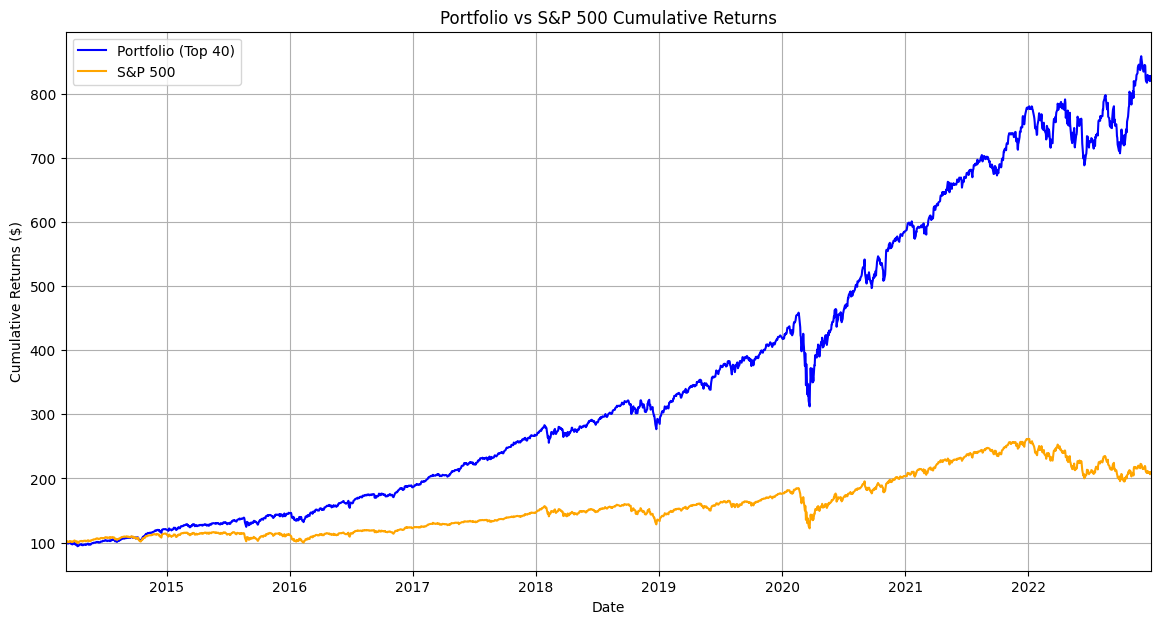

In [ ]:
# Initialize variables
initial_investment = 100
portfolio_value = initial_investment
cumulative_portfolio_returns = []
yearly_adjusted_weights = {}

# Iterate through yearly ranked stocks and calculate adjusted HRP weights
for year, ranked_stocks in yearly_ranked_stocks.items():
    print(f"\nApplying HRP for year {year}...")

    # Select the top 40 ranked stocks
    top_ranked_stocks = ranked_stocks.head(40)
    tickers = top_ranked_stocks['Ticker']
    filtered_data = all_stocks_data[all_stocks_data['Ticker'].isin(tickers)]

    # Pivot to get price data
    price_data = filtered_data.pivot(index='Date', columns='Ticker', values='Close')

    # Handle missing data
    if price_data.isnull().any().any():
        print(f"Missing values found in price data for {year}. Handling them...")
        price_data = price_data.ffill().bfill()

    # Calculate daily returns
    returns = price_data.pct_change().dropna()

    # Apply HRP algorithm
    hrp = HRPOpt(returns)
    hrp_weights = hrp.optimize()

    # Convert HRP weights to DataFrame
    hrp_weights_df = pd.DataFrame.from_dict(hrp_weights, orient='index', columns=['Weight'])
    hrp_weights_df.index.name = 'Ticker'
    hrp_weights_df.sort_values(by='Weight', ascending=False, inplace=True)

    # Adjust weights using probabilities
    probabilities = top_ranked_stocks.set_index('Ticker')['Probability_of_Positive_Return']
    aligned_probabilities = probabilities.reindex(hrp_weights_df.index).dropna()
    hrp_weights_df = hrp_weights_df.loc[aligned_probabilities.index]

    # Calculate adjusted weights
    adjusted_weights = hrp_weights_df['Weight'] * aligned_probabilities
    adjusted_weights /= adjusted_weights.sum()

    # Create adjusted weights DataFrame
    adjusted_weights_df = adjusted_weights.to_frame('Adjusted Weight')
    adjusted_weights_df.index.name = 'Ticker'
    adjusted_weights_df.sort_values(by='Adjusted Weight', ascending=False, inplace=True)

    # Store the adjusted weights
    yearly_adjusted_weights[year] = adjusted_weights_df

    print(f"\nAdjusted HRP Weights for Top 40 Ranked Stocks for {year}:")
    print(adjusted_weights_df.head())

# Simulate portfolio performance year by year
for year, adjusted_weights_df in yearly_adjusted_weights.items():
    print(f"\nSimulating portfolio for year {year}...")

    # Filter data for the selected tickers
    tickers = adjusted_weights_df.index
    filtered_data = all_stocks_data[all_stocks_data['Ticker'].isin(tickers)]
    price_data_year = filtered_data.pivot(index='Date', columns='Ticker', values='Close')
    price_data_year = price_data_year.loc[f"{year}-01-01":f"{year}-12-31"]

    # Handle missing data
    price_data_year = price_data_year.ffill().bfill()

    # Calculate daily returns
    returns_year = price_data_year.pct_change().dropna()

    # Calculate weighted portfolio returns
    portfolio_returns = returns_year[adjusted_weights_df.index]
    weighted_returns = portfolio_returns.mul(adjusted_weights_df['Adjusted Weight'], axis=1)
    portfolio_daily_returns = weighted_returns.sum(axis=1)

    # Calculate cumulative returns
    yearly_cumulative_returns = (1 + portfolio_daily_returns).cumprod()
    yearly_cumulative_returns *= portfolio_value

    # Update portfolio value and store yearly returns
    portfolio_value = yearly_cumulative_returns.iloc[-1]
    cumulative_portfolio_returns.append(yearly_cumulative_returns)

# Combine yearly cumulative returns into a single series
final_cumulative_returns = pd.concat(cumulative_portfolio_returns).sort_index()

# --------------------------------------------
# Step 6: Benchmark and Visualization
# --------------------------------------------
# Download historical price data for S&P 500
sp500_data = yf.download('^GSPC', start=f"{start_year}-01-01", end=f"{end_year}-12-31")['Adj Close']
sp500_returns = sp500_data.pct_change().dropna()
sp500_cumulative_returns = (1 + sp500_returns).cumprod() * initial_investment

# Align indices
sp500_cumulative_returns.index = pd.to_datetime(sp500_cumulative_returns.index)
final_cumulative_returns.index = pd.to_datetime(final_cumulative_returns.index)

# Plot cumulative returns
plt.figure(figsize=(14, 7))
plt.plot(final_cumulative_returns, label='Portfolio (Top 40)', color='blue')
plt.plot(sp500_cumulative_returns.loc[final_cumulative_returns.index], label='S&P 500', color='orange')
plt.title('XGBOOST vs S&P 500 Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns ($)')
plt.legend()
plt.grid(True)

# Set x-axis to yearly intervals
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xlim(final_cumulative_returns.index.min(), final_cumulative_returns.index.max())

plt.show()

# Comparing Results

In [29]:
# Function to compute performance metrics
def calculate_performance_metrics(returns_series, risk_free_rate=0.0):
    # Check if the series is empty
    if returns_series.empty:
        raise ValueError("The returns series is empty. Check your data and calculations.")

    # Calculate total return
    total_return = returns_series.iloc[-1] / returns_series.iloc[0] - 1

    # Calculate the number of years in the returns series
    num_years = (returns_series.index[-1] - returns_series.index[0]).days / 365.25

    # Calculate annualized return
    annualized_return = (1 + total_return) ** (1 / num_years) - 1

    # Calculate annualized volatility
    annualized_volatility = returns_series.pct_change().std() * np.sqrt(252)

    # Calculate Sharpe ratio
    sharpe_ratio = (annualized_return - risk_free_rate) / annualized_volatility

    return {
        'Total Return': total_return,
        'Annualized Return': annualized_return,
        'Annualized Volatility': annualized_volatility,
        'Sharpe Ratio': sharpe_ratio
    }

# Calculate metrics for the portfolio
portfolio_metrics = calculate_performance_metrics(final_cumulative_returns)

# Calculate metrics for the S&P 500
sp500_metrics = calculate_performance_metrics(sp500_cumulative_returns)

# Convert S&P 500 metrics into scalar values (remove index metadata)
sp500_metrics_cleaned = {key: float(value) for key, value in sp500_metrics.items()}

# Create a DataFrame with the metrics for comparison
metrics_df = pd.DataFrame(
    [portfolio_metrics, sp500_metrics_cleaned], 
    index=['Your Portfolio', 'S&P 500']
)

# Display the metrics
print("\nPortfolio vs. S&P 500 Performance Metrics:")
metrics_df



Portfolio vs. S&P 500 Performance Metrics:


C:\Users\Alec\AppData\Local\Temp\ipykernel_20256\2732809231.py:36: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sp500_metrics_cleaned = {key: float(value) for key, value in sp500_metrics.items()}


,Total Return,Annualized Return,Annualized Volatility,Sharpe Ratio
Your Portfolio,7.228406,0.270065,0.176987,1.525897
S&P 500,1.096518,0.085846,0.181824,0.472138


# LSTM 
### Doesn't use sequencing because each row has 30 lagged days


Processing year 2014...
Fitting 5 folds for each of 10 candidates, totalling 50 fits

Best Hyperparameters for 2014: {'module__num_layers': 3, 'module__hidden_size': 150, 'max_epochs': 50, 'lr': 0.01, 'iterator_valid__batch_size': 32, 'iterator_train__batch_size': 64}
Year 2014 - LSTM Test Set F1-Score: 0.6819
Tickers length: 20033, Probabilities length: 20033
Top 5 ranked stocks for 2014:
  Ticker  Probability_of_Positive_Return
0   AAPL                        0.989490
1   AVGO                        0.936163
2    BLK                        0.933166
3   VRTX                        0.920593
4    LMT                        0.920233

Processing year 2015...


c:\Users\Alec\Projects\MyEnv\Lib\site-packages\pypfopt\hierarchical_portfolio.py:138: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.56275353 0.56275353 0.56275353 0.56275353 0.56275353 0.56275353
 0.56275353 0.56275353 0.56275353 0.56275353 0.56275353 0.56275353
 0.56275353 0.56275353 0.56275353 0.56275353 0.56275353 0.56275353
 0.56275353 0.56275353]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  w[first_cluster] *= alpha  # weight 1


Fitting 5 folds for each of 10 candidates, totalling 50 fits

Best Hyperparameters for 2015: {'module__num_layers': 2, 'module__hidden_size': 100, 'max_epochs': 50, 'lr': 0.001, 'iterator_valid__batch_size': 32, 'iterator_train__batch_size': 32}
Year 2015 - LSTM Test Set F1-Score: 0.5935
Tickers length: 24316, Probabilities length: 24316
Top 5 ranked stocks for 2015:
  Ticker  Probability_of_Positive_Return
0   META                        0.926492
1   NVDA                        0.849808
2    NOW                        0.676462
3   MSFT                        0.665489
4    BAC                        0.662011

Processing year 2016...


c:\Users\Alec\Projects\MyEnv\Lib\site-packages\pypfopt\hierarchical_portfolio.py:138: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.47053698 0.47053698 0.47053698 0.47053698 0.47053698 0.47053698
 0.47053698 0.47053698 0.47053698 0.47053698 0.47053698 0.47053698
 0.47053698 0.47053698 0.47053698 0.47053698 0.47053698 0.47053698
 0.47053698 0.47053698]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  w[first_cluster] *= alpha  # weight 1


Fitting 5 folds for each of 10 candidates, totalling 50 fits

Best Hyperparameters for 2016: {'module__num_layers': 2, 'module__hidden_size': 150, 'max_epochs': 50, 'lr': 0.001, 'iterator_valid__batch_size': 64, 'iterator_train__batch_size': 64}
Year 2016 - LSTM Test Set F1-Score: 0.6845
Tickers length: 24444, Probabilities length: 24444
Top 5 ranked stocks for 2016:
  Ticker  Probability_of_Positive_Return
0    AMD                        0.999396
1   NVDA                        0.994773
2   BKNG                        0.959099
3    KKR                        0.955295
4     MU                        0.933571

Processing year 2017...


c:\Users\Alec\Projects\MyEnv\Lib\site-packages\pypfopt\hierarchical_portfolio.py:138: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.60074947 0.60074947 0.60074947 0.60074947 0.60074947 0.60074947
 0.60074947 0.60074947 0.60074947 0.60074947 0.60074947 0.60074947
 0.60074947 0.60074947 0.60074947 0.60074947 0.60074947 0.60074947
 0.60074947 0.60074947]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  w[first_cluster] *= alpha  # weight 1


Fitting 5 folds for each of 10 candidates, totalling 50 fits

Best Hyperparameters for 2017: {'module__num_layers': 2, 'module__hidden_size': 100, 'max_epochs': 50, 'lr': 0.005, 'iterator_valid__batch_size': 16, 'iterator_train__batch_size': 32}
Year 2017 - LSTM Test Set F1-Score: 0.6884
Tickers length: 24347, Probabilities length: 24347
Top 5 ranked stocks for 2017:
  Ticker  Probability_of_Positive_Return
0   NVDA                        0.992616
1    KKR                        0.984962
2    BLK                        0.983682
3    LMT                        0.965374
4   SPGI                        0.954548

Processing year 2018...


c:\Users\Alec\Projects\MyEnv\Lib\site-packages\pypfopt\hierarchical_portfolio.py:138: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.70637867 0.70637867 0.70637867 0.70637867 0.70637867 0.70637867
 0.70637867 0.70637867 0.70637867 0.70637867 0.70637867 0.70637867
 0.70637867 0.70637867 0.70637867 0.70637867 0.70637867 0.70637867
 0.70637867 0.70637867]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  w[first_cluster] *= alpha  # weight 1


Fitting 5 folds for each of 10 candidates, totalling 50 fits

Best Hyperparameters for 2018: {'module__num_layers': 2, 'module__hidden_size': 100, 'max_epochs': 50, 'lr': 0.001, 'iterator_valid__batch_size': 32, 'iterator_train__batch_size': 32}
Year 2018 - LSTM Test Set F1-Score: 0.6430
Tickers length: 24250, Probabilities length: 24250
Top 5 ranked stocks for 2018:
  Ticker  Probability_of_Positive_Return
0   VRTX                        0.866196
1    NOW                        0.851111
2    AMD                        0.840639
3     DE                        0.825359
4   ISRG                        0.809705

Processing year 2019...


c:\Users\Alec\Projects\MyEnv\Lib\site-packages\pypfopt\hierarchical_portfolio.py:138: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.5583078 0.5583078 0.5583078 0.5583078 0.5583078 0.5583078 0.5583078
 0.5583078 0.5583078 0.5583078 0.5583078 0.5583078 0.5583078 0.5583078
 0.5583078 0.5583078 0.5583078 0.5583078 0.5583078 0.5583078]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  w[first_cluster] *= alpha  # weight 1


Fitting 5 folds for each of 10 candidates, totalling 50 fits

Best Hyperparameters for 2019: {'module__num_layers': 1, 'module__hidden_size': 50, 'max_epochs': 50, 'lr': 0.001, 'iterator_valid__batch_size': 32, 'iterator_train__batch_size': 32}
Year 2019 - LSTM Test Set F1-Score: 0.5666
Tickers length: 24430, Probabilities length: 24430
Top 5 ranked stocks for 2019:
  Ticker  Probability_of_Positive_Return
0    KKR                        0.863040
1   NVDA                        0.839597
2   TSLA                        0.803948
3   UBER                        0.803934
4   AVGO                        0.783164

Processing year 2020...


c:\Users\Alec\Projects\MyEnv\Lib\site-packages\pypfopt\hierarchical_portfolio.py:138: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.74017317 0.74017317 0.74017317 0.74017317 0.74017317 0.74017317
 0.74017317 0.74017317 0.74017317 0.74017317 0.74017317 0.74017317
 0.74017317 0.74017317 0.74017317 0.74017317 0.74017317 0.74017317
 0.74017317 0.74017317]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  w[first_cluster] *= alpha  # weight 1


Fitting 5 folds for each of 10 candidates, totalling 50 fits

Best Hyperparameters for 2020: {'module__num_layers': 2, 'module__hidden_size': 100, 'max_epochs': 50, 'lr': 0.005, 'iterator_valid__batch_size': 16, 'iterator_train__batch_size': 32}
Year 2020 - LSTM Test Set F1-Score: 0.7815
Tickers length: 24696, Probabilities length: 24696
Top 5 ranked stocks for 2020:
  Ticker  Probability_of_Positive_Return
0   AAPL                        0.993928
1   TSLA                        0.970279
2    BLK                        0.930598
3   NVDA                        0.924295
4    AMD                        0.909518

Processing year 2021...


c:\Users\Alec\Projects\MyEnv\Lib\site-packages\pypfopt\hierarchical_portfolio.py:138: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.58250961 0.58250961 0.58250961 0.58250961 0.58250961 0.58250961
 0.58250961 0.58250961 0.58250961 0.58250961 0.58250961 0.58250961
 0.58250961 0.58250961 0.58250961 0.58250961 0.58250961 0.58250961
 0.58250961 0.58250961]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  w[first_cluster] *= alpha  # weight 1


Fitting 5 folds for each of 10 candidates, totalling 50 fits

Best Hyperparameters for 2021: {'module__num_layers': 2, 'module__hidden_size': 100, 'max_epochs': 50, 'lr': 0.001, 'iterator_valid__batch_size': 32, 'iterator_train__batch_size': 32}
Year 2021 - LSTM Test Set F1-Score: 0.7004
Tickers length: 24835, Probabilities length: 24835
Top 5 ranked stocks for 2021:
  Ticker  Probability_of_Positive_Return
0    KKR                        0.918466
1   ANET                        0.864772
2    BSX                        0.847318
3    COP                        0.834081
4   NVDA                        0.832038

Processing year 2022...


c:\Users\Alec\Projects\MyEnv\Lib\site-packages\pypfopt\hierarchical_portfolio.py:138: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.51886584 0.51886584 0.51886584 0.51886584 0.51886584 0.51886584
 0.51886584 0.51886584 0.51886584 0.51886584 0.51886584 0.51886584
 0.51886584 0.51886584 0.51886584 0.51886584 0.51886584 0.51886584
 0.51886584 0.51886584]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  w[first_cluster] *= alpha  # weight 1


Fitting 5 folds for each of 10 candidates, totalling 50 fits

Best Hyperparameters for 2022: {'module__num_layers': 2, 'module__hidden_size': 100, 'max_epochs': 50, 'lr': 0.001, 'iterator_valid__batch_size': 32, 'iterator_train__batch_size': 32}
Year 2022 - LSTM Test Set F1-Score: 0.6466


c:\Users\Alec\Projects\MyEnv\Lib\site-packages\pypfopt\hierarchical_portfolio.py:138: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.70302191 0.70302191 0.70302191 0.70302191 0.70302191 0.70302191
 0.70302191 0.70302191 0.70302191 0.70302191 0.70302191 0.70302191
 0.70302191 0.70302191 0.70302191 0.70302191 0.70302191 0.70302191
 0.70302191 0.70302191]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  w[first_cluster] *= alpha  # weight 1
[*********************100%***********************]  1 of 1 completed

Tickers length: 24849, Probabilities length: 24849
Top 5 ranked stocks for 2022:
  Ticker  Probability_of_Positive_Return
0    BSX                        0.732562
1     GE                        0.660054
2    TJX                        0.650659
3   GILD                        0.642614
4   UBER                        0.634847


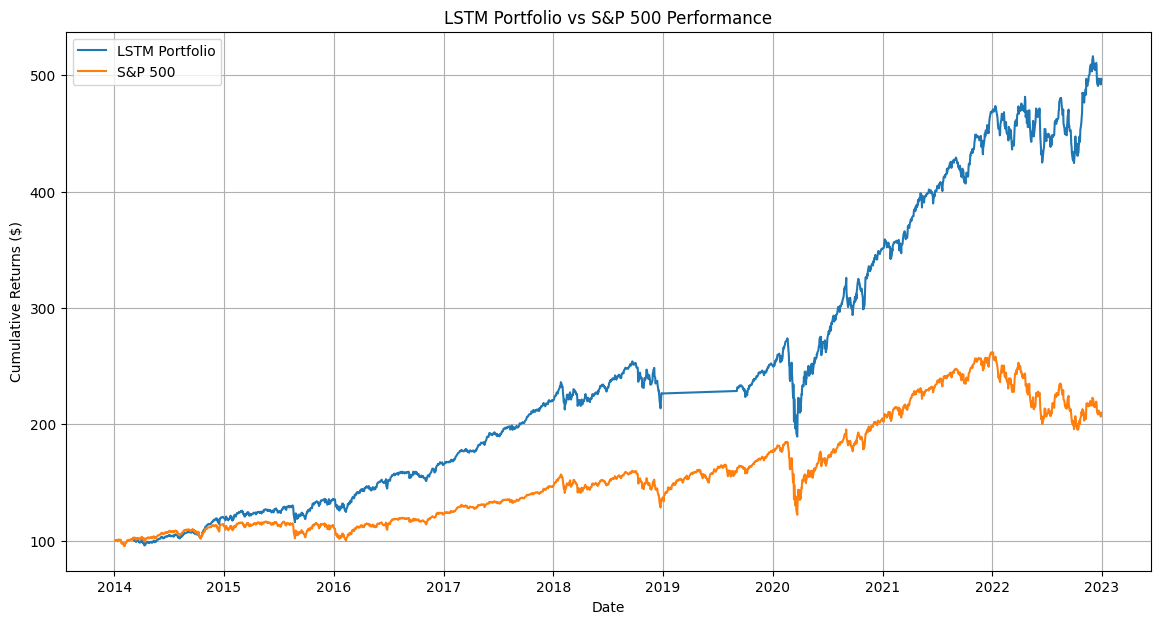


F1-Scores for LSTM across all years (Test Set):
Year 2014: F1-Score = 0.6819
Year 2015: F1-Score = 0.5935
Year 2016: F1-Score = 0.6845
Year 2017: F1-Score = 0.6884
Year 2018: F1-Score = 0.6430
Year 2019: F1-Score = 0.5666
Year 2020: F1-Score = 0.7815
Year 2021: F1-Score = 0.7004
Year 2022: F1-Score = 0.6466


In [30]:
# Initialize variables
initial_investment = 100
lstm_portfolio_value = initial_investment
lstm_cumulative_portfolio_returns = []
f1_scores_lstm_per_year = {}
try:
    best_lstm_models = json.load(open("ltsm_hyper_params.json"))
except FileNotFoundError:
    open("ltsm_hyper_params.json", "x").write("{}")
    best_lstm_models = {}

# Define feature columns and target
feature_columns = [
    col for col in all_stocks_data.columns if col not in ['Ticker', 'Return_90d', 'Target', 'Date']
]

# --------------------------------------------
# Step 2: Define LSTM Model
# --------------------------------------------
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=50, num_layers=2, output_size=2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add time dimension
        lstm_out, (hn, _) = self.lstm(x)
        out = self.fc(hn[-1])  # Output from the last hidden layer
        return out

# --------------------------------------------
# Step 3: Hyperparameter Grid for RandomizedSearchCV
# --------------------------------------------
param_dist = {
    'module__hidden_size': [50, 100, 150],
    'module__num_layers': [1, 2, 3],
    'lr': [0.001, 0.005, 0.01],
    'iterator_train__batch_size': [16, 32, 64],
    'iterator_valid__batch_size': [16, 32, 64],
    'max_epochs': [25, 50],
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# --------------------------------------------
# Step 4: Yearly Training and Portfolio Construction
# --------------------------------------------
for year in range(start_year, end_year + 1):
    with open("ltsm_hyper_params.json", "w") as f:
        f.write(json.dumps(best_lstm_models))

    print(f"\nProcessing year {year}...")

    # Filter data for the current year
    yearly_data = all_stocks_data[
        (all_stocks_data['Date'] >= f"{year}-01-01") &
        (all_stocks_data['Date'] <= f"{year}-12-31")
    ]

    if yearly_data.empty:
        print(f"No data available for year {year}. Skipping...")
        continue

    # Extract features and target
    X_year = yearly_data[feature_columns]
    y_year = yearly_data['Target']

    # Handle missing data
    X_year = X_year.replace([np.inf, -np.inf], np.nan).dropna()
    y_year = y_year.loc[X_year.index]
    if X_year.empty:
        print(f"No valid data for year {year}. Skipping...")
        continue

    # Normalize the features
    scaler = MinMaxScaler()
    X_year_scaled = scaler.fit_transform(X_year)

    # Split into training, validation, and test sets
    X_train, X_temp, y_train, y_temp = train_test_split(
        X_year_scaled, y_year, test_size=0.4, random_state=42, stratify=y_year
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
    )
    y_train = y_train.astype(int)

    if str(year) not in best_lstm_models:
        # Wrap LSTM with Skorch for RandomizedSearchCV
        net = NeuralNetClassifier(
            module=LSTMModel,
            module__input_size=X_year_scaled.shape[1],
            module__hidden_size=50,
            module__num_layers=2,
            module__output_size=len(np.unique(y_year)),
            criterion=nn.CrossEntropyLoss,
            optimizer=torch.optim.Adam,
            train_split=None,
            verbose=0,
            device='cuda' if torch.cuda.is_available() else 'cpu',
        )

        # Perform RandomizedSearchCV
        random_search = RandomizedSearchCV(
            estimator=net,
            param_distributions=param_dist,
            n_iter=10,  # Adjust based on computational resources
            scoring='accuracy',
            cv=skf,
            verbose=2,
            random_state=42,
            n_jobs=4
        )

        random_search.fit(X_train.astype(np.float32), y_train)

        # Get the best model and hyperparameters
        best_lstm_model = random_search.best_estimator_
        print(f"\nBest Hyperparameters for {year}: {random_search.best_params_}")
        best_lstm_models[str(year)] = random_search.best_params_
    else:
        best_lstm_model = NeuralNetClassifier(
            module=LSTMModel,
            module__input_size=X_year_scaled.shape[1],
            module__output_size=len(np.unique(y_year)),
            criterion=nn.CrossEntropyLoss,
            optimizer=torch.optim.Adam,
            train_split=None,
            verbose=0,
            device='cuda' if torch.cuda.is_available() else 'cpu',
            **best_lstm_models[str(year)]
        )
        best_lstm_model.fit(X_train.astype(np.float32), y_train)
    
    # Evaluate the model on the test set and save F1-score
    y_test_pred_lstm = best_lstm_model.predict(X_test.astype(np.float32))
    lstm_f1_score_test = f1_score(y_test, y_test_pred_lstm, average='weighted')
    f1_scores_lstm_per_year[year] = lstm_f1_score_test
    print(f"Year {year} - LSTM Test Set F1-Score: {lstm_f1_score_test:.4f}")

    # Predict probabilities for the current year's data
    probabilities_lstm = best_lstm_model.predict_proba(X_year_scaled.astype(np.float32))[:, 1]

    # Ensure tickers align with probabilities
    tickers = yearly_data['Ticker'].iloc[:len(probabilities_lstm)]
    print(f"Tickers length: {len(tickers)}, Probabilities length: {len(probabilities_lstm)}")

    # Create a ranked stocks DataFrame
    ranked_stocks_lstm = pd.DataFrame({
        'Ticker': tickers.values,
        'Probability_of_Positive_Return': probabilities_lstm
    })
    ranked_stocks_lstm = ranked_stocks_lstm.groupby('Ticker', as_index=False)['Probability_of_Positive_Return'].mean()
    ranked_stocks_lstm = ranked_stocks_lstm.sort_values(by='Probability_of_Positive_Return', ascending=False).reset_index(drop=True)

    # Select only the top 40 stocks
    top_40_stocks = ranked_stocks_lstm.head(40)

    # Display the top-ranked stocks for the year
    print(f"Top 5 ranked stocks for {year}:")
    print(top_40_stocks.head())

    # Filter and prepare price data for HRP
    filtered_data_lstm = yearly_data[yearly_data['Ticker'].isin(top_40_stocks['Ticker'])]
    price_data_year_lstm = filtered_data_lstm.pivot(index='Date', columns='Ticker', values='Close').dropna()
    returns_year_lstm = price_data_year_lstm.pct_change().dropna()

    # Apply HRP
    hrp_lstm = HRPOpt(returns_year_lstm)
    hrp_weights_lstm = hrp_lstm.optimize()

    # Adjust HRP weights with probabilities
    hrp_weights_df_lstm = pd.DataFrame.from_dict(hrp_weights_lstm, orient='index', columns=['Weight'])
    hrp_weights_df_lstm.index.name = 'Ticker'
    probabilities_series_lstm = top_40_stocks.set_index('Ticker')['Probability_of_Positive_Return']
    aligned_probabilities_lstm = probabilities_series_lstm.reindex(hrp_weights_df_lstm.index).dropna()
    adjusted_weights_lstm = (hrp_weights_df_lstm['Weight'] * aligned_probabilities_lstm).div(
        (hrp_weights_df_lstm['Weight'] * aligned_probabilities_lstm).sum()
    )
    adjusted_weights_df_lstm = adjusted_weights_lstm.to_frame('Adjusted Weight')

    # Calculate the portfolio's daily returns
    portfolio_returns_lstm = returns_year_lstm[adjusted_weights_df_lstm.index].mul(
        adjusted_weights_df_lstm['Adjusted Weight'], axis=1
    ).sum(axis=1)

    # Calculate cumulative returns for the year
    lstm_yearly_cumulative_returns = (1 + portfolio_returns_lstm).cumprod() * lstm_portfolio_value

    # Update the portfolio value for the end of the year
    lstm_portfolio_value = lstm_yearly_cumulative_returns.iloc[-1]

    # Store cumulative returns for the year
    lstm_cumulative_portfolio_returns.append(lstm_yearly_cumulative_returns)

# Combine yearly returns into a single series
final_lstm_cumulative_returns = pd.concat(lstm_cumulative_portfolio_returns).sort_index()

# --------------------------------------------
# Step 5: Benchmark and Visualization
# --------------------------------------------
sp500_data = yf.download('^GSPC', start=f"{start_year}-01-01", end=f"{end_year}-12-31")['Adj Close']
sp500_cumulative_returns = (1 + sp500_data.pct_change().dropna()).cumprod() * initial_investment

# Ensure indices are DatetimeIndex
final_lstm_cumulative_returns.index = pd.to_datetime(final_lstm_cumulative_returns.index)
sp500_cumulative_returns.index = pd.to_datetime(sp500_cumulative_returns.index)

# Plot portfolio vs. S&P 500
plt.figure(figsize=(14, 7))
plt.plot(final_lstm_cumulative_returns, label='LSTM Portfolio')
plt.plot(sp500_cumulative_returns, label='S&P 500')
plt.title('LSTM Portfolio vs S&P 500 Performance')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns ($)')
plt.legend()
plt.grid(True)
plt.show()

# Print the yearly F1-scores for LSTM
print("\nF1-Scores for LSTM across all years (Test Set):")
for year, f1 in f1_scores_lstm_per_year.items():
    print(f"Year {year}: F1-Score = {f1:.4f}")

In [ ]:
best_lstm_model = NeuralNetClassifier(module=LSTMModel,
            module__input_size=X_year_scaled.shape[1],
            module__output_size=len(np.unique(y_year)),
            criterion=nn.CrossEntropyLoss,
            optimizer=torch.optim.Adam,
            train_split=None,
            verbose=0,
            device='cuda' if torch.cuda.is_available() else 'cpu',
            **best_lstm_models[str(year)])

In [ ]:
'''
best_lstm_models = {
    "2014": {'module__num_layers': 2, 'module__hidden_size': 100, 'max_epochs': 50, 'lr': 0.001, 'iterator_valid__batch_size': 32, 'iterator_train__batch_size': 32},
    "2015": {'module__num_layers': 2, 'module__hidden_size': 100, 'max_epochs': 50, 'lr': 0.001, 'iterator_valid__batch_size': 32, 'iterator_train__batch_size': 32},
    "2016": {'module__num_layers': 2, 'module__hidden_size': 150, 'max_epochs': 50, 'lr': 0.001, 'iterator_valid__batch_size': 64, 'iterator_train__batch_size': 64},
    "2017": {'module__num_layers': 2, 'module__hidden_size': 100, 'max_epochs': 50, 'lr': 0.005, 'iterator_valid__batch_size': 16, 'iterator_train__batch_size': 32},
    "2018": {'module__num_layers': 2, 'module__hidden_size': 100, 'max_epochs': 50, 'lr': 0.001, 'iterator_valid__batch_size': 32, 'iterator_train__batch_size': 32},
    "2019": {'module__num_layers': 1, 'module__hidden_size': 50, 'max_epochs': 50, 'lr': 0.001, 'iterator_valid__batch_size': 32, 'iterator_train__batch_size': 32},
    "2020": {'module__num_layers': 2, 'module__hidden_size': 100, 'max_epochs': 50, 'lr': 0.005, 'iterator_valid__batch_size': 16, 'iterator_train__batch_size': 32},
    "2021": {'module__num_layers': 2, 'module__hidden_size': 100, 'max_epochs': 50, 'lr': 0.001, 'iterator_valid__batch_size': 32, 'iterator_train__batch_size': 32},
    "2022": {'module__num_layers': 2, 'module__hidden_size': 100, 'max_epochs': 50, 'lr': 0.005, 'iterator_valid__batch_size': 16, 'iterator_train__batch_size': 32},
}
'''

[2014.0, 2015.0, 2016.0, 2017.0, 2018.0, 2019.0, 2020.0, 2021.0, 2022.0]

# Evaluate XGBooster and LSTM Models 

In [ ]:
# Ensure F1-scores are converted to standard Python floats
f1_scores_lstm_per_year = [float(score) for score in f1_scores_lstm_per_year]
f1_scores_xgb_per_year = [float(score) for score in f1_scores_xgb_per_year]

# --------------------------------------------
# Perform Statistical Analysis
# --------------------------------------------

# Print the collected F1-scores
print(f"\nYearly LSTM F1-scores: {f1_scores_lstm_per_year}")
print(f"Yearly XGBoost F1-scores: {f1_scores_xgb_per_year}")

# Compute the mean and standard deviation of the F1-scores
print(f"LSTM F1-Score Mean: {np.mean(f1_scores_lstm_per_year):.4f}, Std Dev: {np.std(f1_scores_lstm_per_year):.4f}")
print(f"XGBoost F1-Score Mean: {np.mean(f1_scores_xgb_per_year):.4f}, Std Dev: {np.std(f1_scores_xgb_per_year):.4f}")

# Perform a paired t-test to compare the models' F1-scores across years
t_stat, p_value_t = ttest_rel(f1_scores_lstm_per_year, f1_scores_xgb_per_year)
print(f"\nPaired t-test: t-statistic = {t_stat:.4f}, p-value = {p_value_t:.4f}")



Yearly LSTM F1-scores: [2014.0, 2015.0, 2016.0, 2017.0, 2018.0, 2019.0, 2020.0, 2021.0, 2022.0]
Yearly XGBoost F1-scores: []
LSTM F1-Score Mean: 2018.0000, Std Dev: 2.5820
XGBoost F1-Score Mean: nan, Std Dev: nan

Paired t-test: t-statistic = nan, p-value = nan


c:\Users\Alec\Projects\MyEnv\Lib\site-packages\numpy\_core\fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\Alec\Projects\MyEnv\Lib\site-packages\numpy\_core\_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\Alec\Projects\MyEnv\Lib\site-packages\numpy\_core\_methods.py:227: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\Alec\Projects\MyEnv\Lib\site-packages\numpy\_core\_methods.py:184: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\Alec\Projects\MyEnv\Lib\site-packages\numpy\_core\_methods.py:219: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\Alec\AppData\Local\Temp\ipykernel_20256\2153416997.py:18: SmallSampleWarning: One or more sample arguments is t

# Comparing Performance of XGBoost LSTM and S&P500

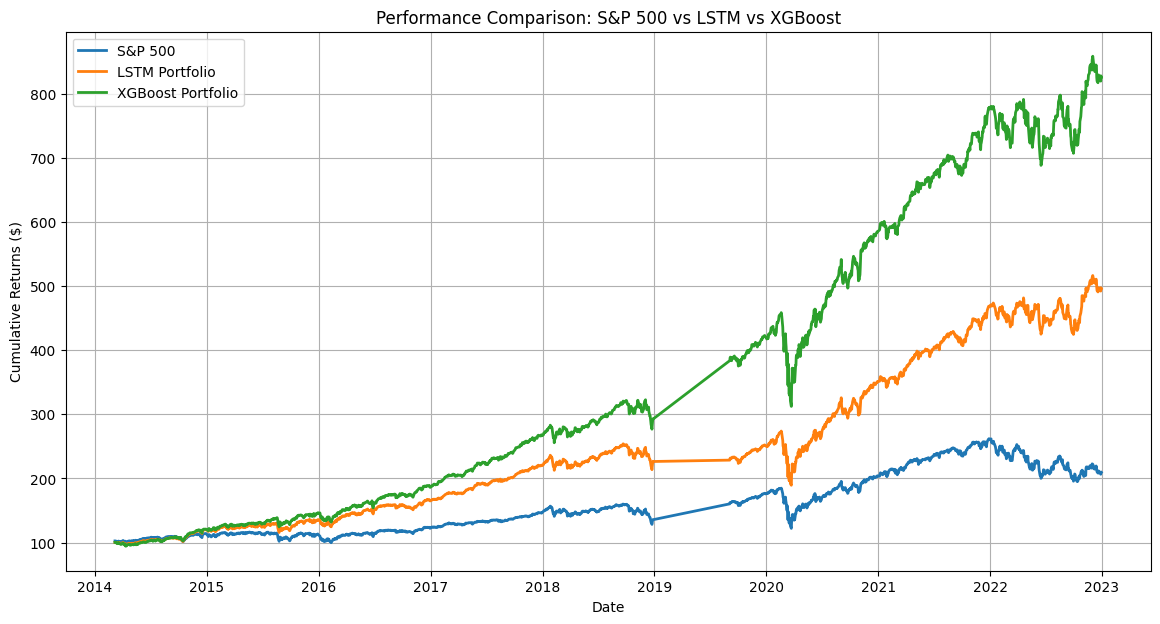

In [32]:
# Ensure cumulative returns for XGBoost, LSTM, and S&P 500 are aligned
combined_data = pd.concat(
    [sp500_cumulative_returns, final_lstm_cumulative_returns, final_cumulative_returns],
    axis=1, 
    join='inner'
)
combined_data.columns = ['S&P 500', 'LSTM Portfolio', 'XGBoost Portfolio']

# Plot the performance over time
plt.figure(figsize=(14, 7))
plt.plot(combined_data.index, combined_data['S&P 500'], label='S&P 500', linewidth=2)
plt.plot(combined_data.index, combined_data['LSTM Portfolio'], label='LSTM Portfolio', linewidth=2)
plt.plot(combined_data.index, combined_data['XGBoost Portfolio'], label='XGBoost Portfolio', linewidth=2)

# Customize the plot
plt.title('Performance Comparison: S&P 500 vs LSTM vs XGBoost')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns ($)')
plt.legend(loc="upper left")
plt.grid(True)

# Show the plot
plt.show()
